# Fluidum Tutorial
F. Capellino, R. Facen, E. Grossi, A. Kirchner

Fluidum is a code to solve relativistic viscous fluid-dynamic equations.

http://arxiv.org/abs/1811.01870

We will solve equations in 1+1 dimensions (r, tau) to compute transverse momentum distributions of identified particles.

In [1]:
using Fluidum

## Fluid Properties

Here we specify the properties of the QGP: shear and bulk viscosity, and the equation of state.

In [83]:
#define equation of state and transport coefficients
eos = FluiduMEoS()

#define transport coefficients
viscosity=QGPViscosity(0.2,0.2) #first number is eta/s
bulk=SimpleBulkViscosity(0.1,15.0) #first number is zeta/s
diffusion=ZeroDiffusion() #do not modify

#collect eos and transport coefficient in the FluidProperties struct
params=Fluidum.FluidProperties(eos,viscosity,bulk,diffusion)

FluidProperties{FluiduMEoS{Float64}, QGPViscosity{Float64}, SimpleBulkViscosity{Float64}, ZeroDiffusion}(FluiduMEoS{Float64}(-15.526548963383643, 18.6159584620131, -10.731808109698516, 2.7413302179949346, -3.3147904483107595, 5.310983721567554, -4.653922019495976, 1.8600649533271152, -1.0465330501411811, 0.09551531822245873), QGPViscosity{Float64}(0.2, 0.2), SimpleBulkViscosity{Float64}(0.1, 15.0), ZeroDiffusion())

## Grid and fields specification

In [84]:
#define a radial grid
gridpoints=100
rmax=20
disc=CartesianDiscretization(OriginInterval(gridpoints,rmax)) 
#define the name and number of fields, with appropriate parity
oned_visc_hydro = oned_visc_hydro=Fields(
    NDField((:even,),(:ghost,),:temperature),
    NDField((:odd,),(:ghost,),:ur),
    NDField((:even,),(:ghost,),:piphiphi),
    NDField((:even,),(:ghost,),:pietaeta),
    NDField((:even,),(:ghost,),:piB)
    )
    
disc_fields = DiscreteFileds(oned_visc_hydro,disc,Float64) 

DiscreteFileds{Float64, 2, 1, 5, (102,), (100,), ((0.0, 20.0),), (0.2,), Float64, Symbol, 25}(Fields{5, 1, Symbol}((NDField{Symbol, 1}((:even,), (:ghost,), :temperature), NDField{Symbol, 1}((:odd,), (:ghost,), :ur), NDField{Symbol, 1}((:even,), (:ghost,), :piphiphi), NDField{Symbol, 1}((:even,), (:ghost,), :pietaeta), NDField{Symbol, 1}((:even,), (:ghost,), :piB))), CartesianDiscretization{1, (100,), ((0.0, 20.0),), (0.2,), Float64}([(-0.1,), (0.1,), (0.30000000000000004,), (0.5000000000000001,), (0.7000000000000001,), (0.9,), (1.1,), (1.3,), (1.5,), (1.7,)  …  (18.3,), (18.5,), (18.7,), (18.9,), (19.1,), (19.3,), (19.5,), (19.7,), (19.9,), (20.1,)]), Fluidum.IndexStructure{2, 1, 5, (102,)}(Vector{CartesianIndex{2}}[[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1)]], Vector{CartesianIndex{2}}[[CartesianIndex(1, 102), CartesianIndex(2, 102), CartesianIndex(3, 102), CartesianIndex(4, 102), CartesianIndex(5, 102)]], CartesianInd

## Initial conditions

Generate the initial conditions profiles using the Glauber model. Generate entropy density profile for the 0-10%, 10-20%, 20-30% and 30-40% centrality classes of PbPb collisions at 5 TeV at the LHC.

In [67]:
using MonteCarloGlauber

1) The independent variable in the code is the temperature, not the entropy. Use the equation of state of an ideal gas of non-interacting quarks (Nf=3, with u,d,s) and gluons to get the temperature profile.
2) Plot the temperature or the entropy in the different centrality classes. What's the difference? You can also compute the total entropy (integral over radial profile) as a function of centrality.

In [166]:
n1= Lead()
n2= Lead()
#You can also try other nuclei: Gold, Copper, Uranium, Xenon

#nuclear parameters (do not modify)
w= 0.5
k=1
p=1.

norm = 0.5 #this modifies the normalization of the entropy profile
s_NN=5000 #center-of-mass energy

#equation of state: entropy to temperature as function of temperature
energy2(T)=T #substitute entropy of the ideal gas of quarks (u,d,s) and gluons 

#signature: eos,(eos),norm,n1,n2,w,k,p,sNN,[centrality classes];#events, radial grid
#notice that it's expensive to generate too many events and to make the grid too large. What's the size of your nucleus?
#this will give you a rough estimate of how much your radial grid should be large.
bg2=MonteCarloGlauber.generate_bg(energy2,1,Lead(),Lead(),w,k,p,s_NN,[10,20,30,40];minBiasEvents=5000,r_grid=0:0.1:10)
#if generate_bg doesn't work, use the commented function (slower but stable)
#bg,twpt=MonteCarloGlauber.generate_bg_two_pt_fct(energy2,energy2,norm,n1,n2,w,k,p,s_NN,[10,20,30,40],[2];minBiasEvents=1000,r_grid=0:0.1:10)

LoadError: UndefVarError: `generate_bg` not defined in `MonteCarloGlauber`
Suggestion: check for spelling errors or missing imports.

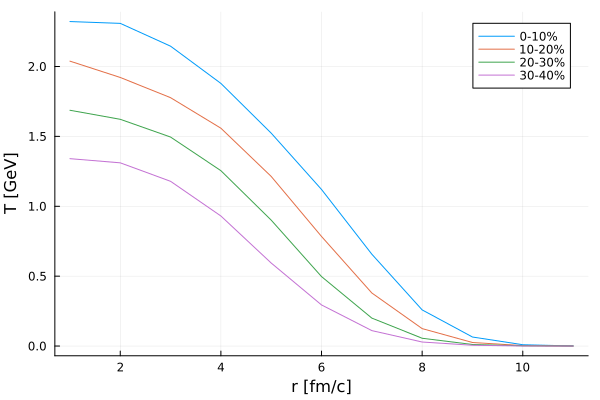

In [91]:
using Plots

plot(bg[1],label="0-10%",xlabel = "r [fm/c]", ylabel="T [GeV]")
plot!(bg[2],label="10-20%")
plot!(bg[3],label="20-30%")
plot!(bg[4],label="30-40%")

You can also look at the entropy density for a single event. This will fluctuate for each event, and doesn't have radial symmetry. This is relevant for flow coefficient calculations, which we won't consider today.

In [85]:
#Plot 10 random events
participants=Participants(n1,n2,2,s_NN,k,p) #you can add one argument at the end to specify a fixed impact parameter
event=rand(participants,10) #second argument is the #events
profile=map(event)   do x 
    map(Iterators.product(-10:0.5:10,-10:0.5:10)) do y
        x(y...)
    end
end

10-element Vector{Matrix{Float64}}:
 [3.3487131755561687e-8 8.731565204516171e-8 … 5.8142443545954356e-8 3.241863943064547e-8; 6.570929747098418e-8 1.7133298235379643e-7 … 1.83810069787957e-7 1.0248921949627186e-7; … ; 6.749884836255652e-17 1.7627791170609214e-16 … 1.402325266725944e-8 7.819333267091014e-9; 1.1580913621828806e-17 3.027353847444575e-17 … 3.873864817348068e-9 2.160058066216624e-9]
 [1.1546052846309174e-6 2.2419291656115835e-6 … 1.0927018567603832e-5 6.949135105102315e-6; 2.8450037878266645e-6 5.492921291599148e-6 … 2.1555495360870503e-5 1.3708061217432704e-5; … ; 2.535563218500264e-8 4.4745988820162745e-8 … 8.869719685608976e-7 4.261190318211183e-7; 7.513241868855133e-9 1.3870181900707955e-8 … 3.641136672412201e-7 1.7502211879255782e-7]
 [6.705390684266861e-7 1.1419467453914896e-6 … 9.048740660866274e-9 4.266002462077465e-9; 1.9381406488042775e-6 3.3007076100898963e-6 … 2.676726736964332e-8 1.2619350336438505e-8; … ; 4.905099552932977e-9 8.353521420186838e-9 … 1.63284467

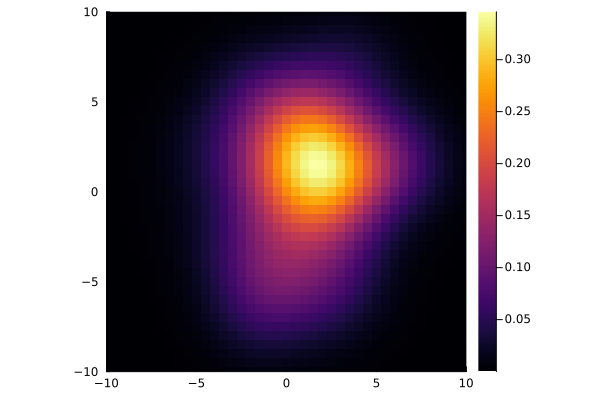

In [86]:
heatmap(-10:0.5:10,-10:0.5:10,profile[10],aspectratio=1,xrange=(-10,10),yrange=(-10,10))

We will need an interpolation of the temperature profile over a larger grid for our simulation. It is best to attach an exponential tail and an atmosphere (small offset) for numerical stability.

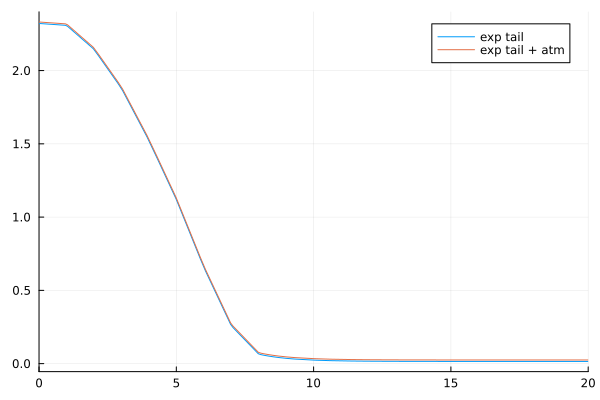

In [167]:
using Interpolations

temp_fun=Interpolations.linear_interpolation(0:1:10,bg[1])
temp_exp_tail(x) = Fluidum.exponential_tail_pointlike.(Ref(temp_fun), x, Ref(8))
#set the temperature field
phi=set_array((x)->0.5*temp_exp_tail(x)+0.01,:temperature,disc_fields); 
plot(x->temp_exp_tail(x),xrange=(0,20),label="exp tail")
plot!(x->temp_exp_tail(x)+0.01,xrange=(0,20), label="exp tail + atm")
#plot!(x->temp_fun(x),xrange=(0,10), label="only trento")

## Fluid evolution

We specify a time range in which we evolve the fluid fields.

3) Plot the fluid fields. How does the fluid velocity (2nd component of the field) change with increasing shear viscosity? What happens to the dissipative fields (components 4 and 5)?

In [168]:
#define a time range for the evolution
tspan = (0.2,5)

#evolve until tspan[2]
nofo=oneshoot(disc_fields,Fluidum.matrxi1d_visc!,params,phi,tspan)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 486-element Vector{Float64}:
 0.2
 0.20000039422701307
 0.20000433649714358
 0.20004375919844855
 0.20043798621149825
 0.20438025634199533
 0.21438025634199534
 0.22438025634199535
 0.23438025634199536
 0.24438025634199537
 0.25438025634199535
 0.26438025634199536
 0.27438025634199537
 ⋮
 4.894380256341935
 4.904380256341935
 4.914380256341935
 4.9243802563419345
 4.934380256341934
 4.944380256341934
 4.954380256341934
 4.964380256341934
 4.9743802563419335
 4.984380256341933
 4.994380256341933
 5.0
u: 486-element Vector{Matrix{Float64}}:
 [1.1701963987455029 1.1701963987455029 … 0.017500966456968303 0.017500966456968303; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [1.170195642018908 1.170195642018908 … 0.017500962610894663 0.017500962610894663; -1.1006015428026061e-9 1.1006015428026061e-9 … 1.0127866454844255e-11 1.0127866454844255e-11; … ; -0.0025574427339137883 -0.0025574427339137883 … -1

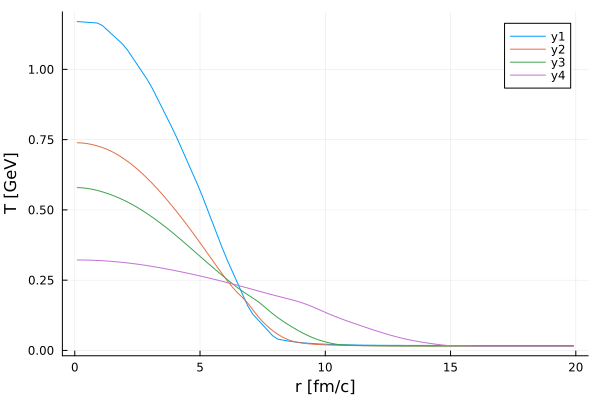

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [169]:
#example: temperature evolution plot
radius = zeros(102)
[radius[i]= disc.grid[i][1] for i in eachindex(disc.grid[1:end])] 
begin
    plot(radius[2:end-1],nofo(tspan[1])[1,2:end-1])
    plot!(radius[2:end-1],nofo(1)[1,2:end-1])
    plot!(radius[2:end-1],nofo(2)[1,2:end-1])
    plot!(radius[2:end-1],nofo(tspan[2])[1,2:end-1], xlabel="r [fm/c]",ylabel = "T [GeV]")
end

## Freeze out

We are now going to compute observables at a freeze out surface, specified by a freeze out temperature (default Tfo = 156.5 MeV).

4) Compute the multiplicity of a particle species. What species among pions, protons and kaons is more abundant?
5) Normalize the spectra of the pions to a fixed value. How does changing the freeze-out temperature affect the pion spectra? 
6) Plot the multiplicities as a function of centrality. How does this relate to the total entropy as a function of centrality?

In [170]:
#specify freeze-out temperature with the optional argument Tfo (in GeV)
tspan = (0.2,30)

fo =freeze_out_routine(disc_fields,Fluidum.matrxi1d_visc!,params,phi,tspan;Tfo=0.1565)

FreezeOutResult{SplineInterp{100, ScaledInterpolation{StaticArraysCore.SVector{2, Float64}, 1, Interpolations.BSplineInterpolation{StaticArraysCore.SVector{2, Float64}, 1, OffsetArrays.OffsetVector{StaticArraysCore.SVector{2, Float64}, Vector{StaticArraysCore.SVector{2, Float64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, (0.028898908438368655,), (1.5623327875258175,)}, SplineInterp{100, ScaledInterpolation{StaticArraysCore.SVector{5, Float64}, 1, Interpolations.BSplineInterpolation{StaticArraysCore.SVector{5, Float64}, 1, OffsetArrays.OffsetVector{StaticArraysCore.SVector{5, Float64}, Vector{StaticArraysCore.SVector{5, Float64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, (0.028898908438368655,), (1.562

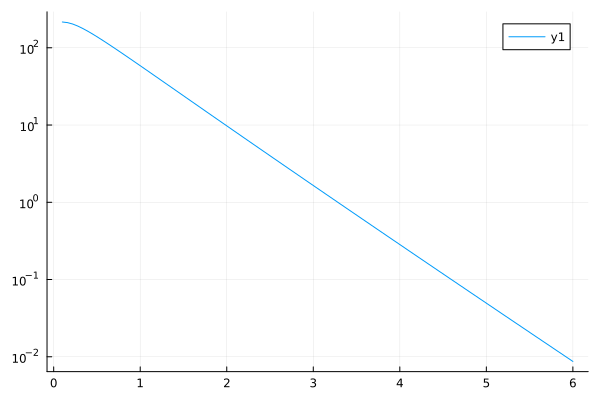

In [176]:
ptrange = range(0.1,6,100)
#signature: ptrange, particle mass, fo surface
#this function produces "thermal" spectra dN/dpt/pt/2pi i.e. without taking resonance decays into account
spectra = [Fluidum.spectra_analitic(ptrange[i],0.200,fo)[1] for i in eachindex(ptrange)]
plot(ptrange,spectra,yscale=:log10)

## Comparison with experimental data

7. Download the experimental data for pion transverse momentum distributions from the ALICE collaboration from HEPdata.

https://www.hepdata.net/record/ins1759506?version=1&table=Table%201

Download them in the CSV format.

8. Plot the data together with the model calculations. What can you see? What is the effect of resonance decays?

## Prequel to Bayesian Inference

To extract QGP properties by a comparison between model and data, it is important to undersand what observables are sensitive to which fluid properties. An example is given by the average transverse momentum $\langle p_T\rangle$.

9. Try to study how $\langle p_T\rangle$ varies as a function of Tfo, $\zeta/s$ and $\eta/s$. Can you tell which property of the fluid will be likely to be constrained by a fit of the model to the $\langle p_T\rangle$?

In [180]:
using QuadGK

In [193]:
#multiplicity
mul = quadgk(b->2*pi*Fluidum.spectra_analitic(b,0.200,fo)[1],0.1,6)[1]
#mean pt
meanpt = quadgk(b->2*pi*b*Fluidum.spectra_analitic(b,0.200,fo)[1],0.1,6)[1]/mul

println(mul)
println(meanpt)

961.2436597602255
0.6892499093038207
